<a href="https://colab.research.google.com/github/Alao001/DL/blob/main/Image_Generation_with_GAN.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip install opendatasets --upgrade --quiet

In [ ]:
import opendatasets as od
dataset_url = 'https://www.kaggle.com/datasets/splcher/animefacedataset'
od.download(dataset_url)

Skipping, found downloaded files in "./animefacedataset" (use force=True to force download)


In [ ]:
import os
data_dir = './animefacedataset'
print(os.listdir(data_dir))

['images']


In [ ]:
print(os.listdir(data_dir + '/images')[:10])

['43818_2013.jpg', '20928_2008.jpg', '413_2000.jpg', '24964_2009.jpg', '8465_2004.jpg', '44658_2013.jpg', '58826_2018.jpg', '59990_2018.jpg', '29691_2010.jpg', '49936_2015.jpg']


Loading Of Dataset

In [ ]:
from torch.utils.data import DataLoader
from torchvision.datasets import ImageFolder
import torchvision.transforms as T

In [ ]:
image_size = 64
batch_size = 128
stats = (0.5, 0.5, 0.5), (0.5, 0.5, 0.5)

In [ ]:
train_ds = ImageFolder(data_dir, transform=T.Compose([
    T.Resize(image_size),
    T.CenterCrop(image_size),
    T.ToTensor(),
    T.Normalize(*stats)]))
train_dl = DataLoader(train_ds,
                      batch_size,
                      shuffle=True,
                      num_workers=3,
                      pin_memory=True)


create helper functions to denomalise the image tensore and display some simple image from the training batch

In [ ]:
import torch
from torchvision.utils import make_grid
import matplotlib.pyplot as plt
%matplotlib inline

In [ ]:
def denorm(img_tensors):
    return img_tensors * stats[1][0] + stats[0][0]

In [ ]:
def show_images(images, nmax=64):
    fig, ax = plt.subplots(figsize=(8, 8))
    ax.set_xticks([]); ax.set_yticks([])
    ax.imshow(make_grid(denorm(images.detach()[:nmax]), nrow=8).permute(1, 2, 0))

def show_batch(dl, nmax=64):
    for images, _ in dl:
        show_images(images, nmax)
        break

In [ ]:
show_batch(train_dl)

In [ ]:
def get_default_device():
    """Pick GPU if available, else CPU"""
    if torch.cuda.is_available():
        return torch.device('cuda')
    else:
        return torch.device('cpu')

def to_device(data, device):
    """Move tensor(s) to chosen device"""
    if isinstance(data, (list,tuple)):
        return [to_device(x, device) for x in data]
    return data.to(device, non_blocking=True)

class DeviceDataLoader():
    """Wrap a dataloader to move data to a device"""
    def __init__(self, dl, device):
        self.dl = dl
        self.device = device

    def __iter__(self):
        """Yield a batch of data after moving it to device"""
        for b in self.dl:
            yield to_device(b, self.device)

    def __len__(self):
        """Number of batches"""
        return len(self.dl)


In [ ]:
device = get_default_device()
device

Move Training data to GPU

In [ ]:
train_dl = DeviceDataLoader(train_dl, device)

Discriminator Network

In [ ]:
import torch.nn as nn

In [ ]:
##------------------------Discriminator using CNN
import torch.nn as nn
discriminator = nn.Sequential(
    # in: 3 x 64 x 64

    nn.Conv2d(3, 64, kernel_size=4, stride=2, padding=1, bias=False),
    nn.BatchNorm2d(64),
    nn.LeakyReLU(0.2, inplace=True),
    # out: 64 x 32 x 32

    nn.Conv2d(64, 128, kernel_size=4, stride=2, padding=1, bias=False),
    nn.BatchNorm2d(128),
    nn.LeakyReLU(0.2, inplace=True),
    # out: 128 x 16 x 16

    nn.Conv2d(128, 256, kernel_size=4, stride=2, padding=1, bias=False),
    nn.BatchNorm2d(256),
    nn.LeakyReLU(0.2, inplace=True),
    # out: 256 x 8 x 8

    nn.Conv2d(256, 512, kernel_size=4, stride=2, padding=1, bias=False),
    nn.BatchNorm2d(512),
    nn.LeakyReLU(0.2, inplace=True),
    # out: 512 x 4 x 4

    nn.Conv2d(512, 1, kernel_size=4, stride=1, padding=0, bias=False),
    # out: 1 x 1 x 1

    nn.Flatten(),
    nn.Sigmoid())


In [ ]:
discriminator = to_device(discriminator, device)

Generator Network by performing transpose convolution (deconvolution)



In [ ]:
latent_size = 128
generator = nn.Sequential(
    # in: latent_size x 1 x 1

    nn.ConvTranspose2d(latent_size, 512, kernel_size=4, stride=1, padding=0, bias=False),
    nn.BatchNorm2d(512),
    nn.ReLU(True),
    # out: 512 x 4 x 4

    nn.ConvTranspose2d(512, 256, kernel_size=4, stride=2, padding=1, bias=False),
    nn.BatchNorm2d(256),
    nn.ReLU(True),
    # out: 256 x 8 x 8

    nn.ConvTranspose2d(256, 128, kernel_size=4, stride=2, padding=1, bias=False),
    nn.BatchNorm2d(128),
    nn.ReLU(True),
    # out: 128 x 16 x 16

    nn.ConvTranspose2d(128, 64, kernel_size=4, stride=2, padding=1, bias=False),
    nn.BatchNorm2d(64),
    nn.ReLU(True),
    # out: 64 x 32 x 32

    nn.ConvTranspose2d(64, 3, kernel_size=4, stride=2, padding=1, bias=False),
    nn.Tanh()
    # out: 3 x 64 x 64
)

torch.Size([128, 3, 64, 64])


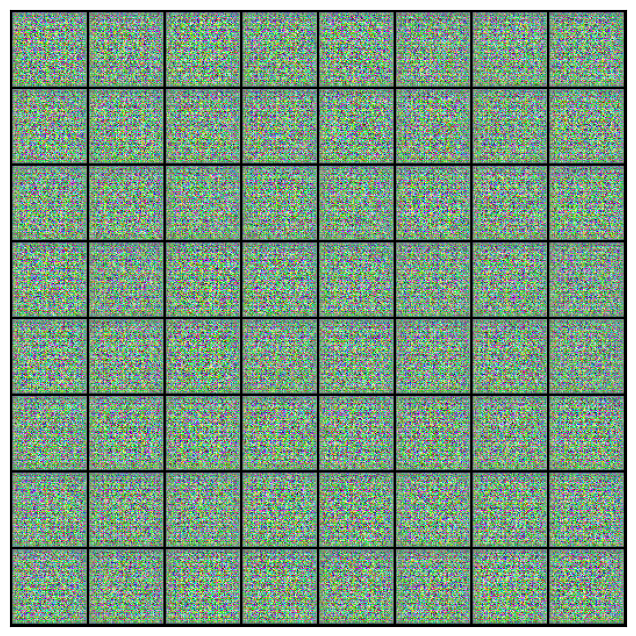

In [ ]:
xb = torch.randn(batch_size, latent_size, 1, 1) # random latent tensors
fake_images = generator(xb)
print(fake_images.shape)
show_images(fake_images)


In [ ]:
# move the generator to device
generator = to_device(generator, device)

Training The Discriminator

In [ ]:
##--------------Discriminator training
def train_discriminator(real_images, opt_d):
    # Clear discriminator gradients
    opt_d.zero_grad()

    # Pass real images through discriminator
    real_preds = discriminator(real_images)
    real_targets = torch.ones(real_images.size(0), 1, device=device)
    real_loss = F.binary_cross_entropy(real_preds, real_targets)
    real_score = torch.mean(real_preds).item()

    # Generate fake images
    latent = torch.randn(batch_size, latent_size, 1, 1, device=device)
    fake_images = generator(latent)

    # Pass fake images through discriminator
    fake_targets = torch.zeros(fake_images.size(0), 1, device=device)
    fake_preds = discriminator(fake_images)
    fake_loss = F.binary_cross_entropy(fake_preds, fake_targets)
    fake_score = torch.mean(fake_preds).item()

    # Update discriminator weights
    loss = real_loss + fake_loss
    loss.backward()
    opt_d.step()
    return loss.item(), real_score, fake_score



Generator Training



In [ ]:
#--------------------Generator training
def train_generator(opt_g):
    # Clear generator gradients
    opt_g.zero_grad()

    # Generate fake images
    latent = torch.randn(batch_size, latent_size, 1, 1, device=device)
    fake_images = generator(latent)

    # Try to fool the discriminator
    preds = discriminator(fake_images)
    targets = torch.ones(batch_size, 1, device=device)
    loss = F.binary_cross_entropy(preds, targets)

    # Update generator weights
    loss.backward()
    opt_g.step()

    return loss.item()

In [ ]:
from torchvision.utils import save_image
sample_dir = 'generated'
os.makedirs(sample_dir, exist_ok=True)

Saving generated-images-0000.png


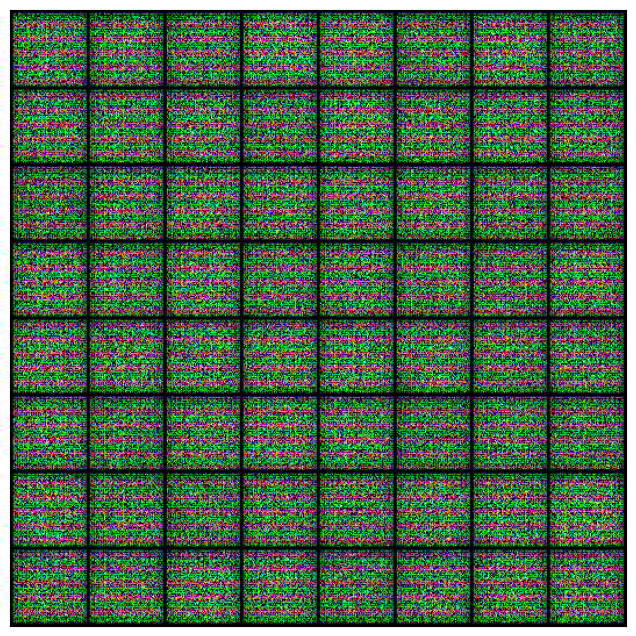

In [ ]:
def save_samples(index, latent_tensors, show=True):
    fake_images = generator(latent_tensors)
    fake_fname = 'generated-images-{0:0=4d}.png'.format(index)
    save_image(denorm(fake_images), os.path.join(sample_dir, fake_fname), nrow=8)
    print('Saving', fake_fname)
    if show:
        fig, ax = plt.subplots(figsize=(8, 8))
        ax.set_xticks([]); ax.set_yticks([])
        ax.imshow(make_grid(fake_images.cpu().detach(), nrow=8).permute(1, 2, 0))

fixed_latent = torch.randn(64, latent_size, 1, 1, device=device)
save_samples(0, fixed_latent)

Saving generated-images-0000.png


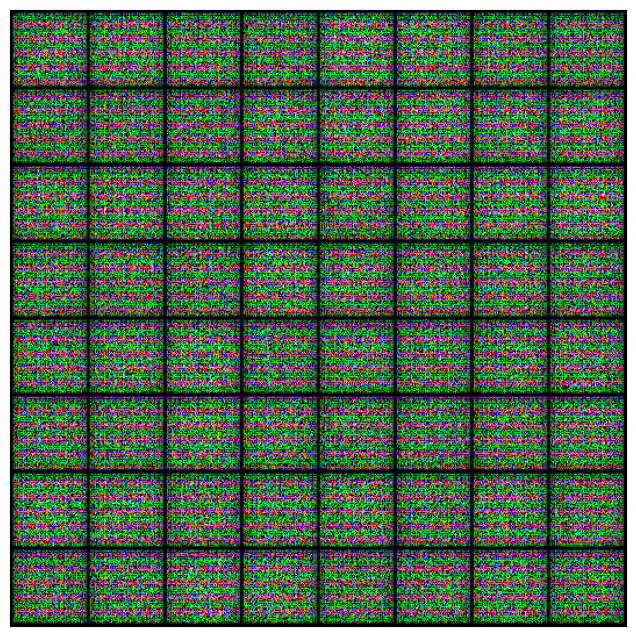

In [ ]:
fixed_latent = torch.randn(64, latent_size, 1, 1, device=device)
save_samples(0, fixed_latent)

In [ ]:
from tqdm.notebook import tqdm
import torch.nn.functional as F

In [ ]:
def fit(epochs, lr, start_idx=1):
    torch.cuda.empty_cache()

    # Losses & scores
    losses_g = []
    losses_d = []
    real_scores = []
    fake_scores = []

    # create optimizer
    opt_d = torch.optim.Adam(discriminator.parameters(), lr=lr, betas=(0.5, 0.999))
    opt_g = torch.optim.Adam(generator.parameters(), lr=lr, betas=(0.5, 0.999))

    for epoch in range(epochs):
        for real_images, _ in tqdm(train_dl):
            # Train discriminator
            loss_d, real_score, fake_score = train_discriminator(real_images, opt_d)
            # Train generator
            loss_g = train_generator(opt_g)
            # Record losses & scores
            losses_g.append(loss_g)
            losses_d.append(loss_d)
            real_scores.append(real_score)
            fake_scores.append(fake_score)

            # Log losses & scores (last batch)
            print("Epoch [{}/{}], loss_g: {:.4f}, loss_d: {:.4f}, real_score: {:.4f}, fake_score: {:.4f}".format(
                epoch+1, epochs, loss_g, loss_d, real_score, fake_score))

        # Save generated images
        save_samples(epoch+start_idx, fixed_latent, show=False)

    return losses_g, losses_d, real_scores, fake_scores

In [ ]:
lr = 0.0002
epochs = 5

In [ ]:
history = fit(epochs, lr)

  0%|          | 0/497 [00:00<?, ?it/s]

Epoch [1/5], loss_g: 2.6096, loss_d: 1.2725, real_score: 0.5632, fake_score: 0.4885
Epoch [1/5], loss_g: 3.4701, loss_d: 0.8516, real_score: 0.9550, fake_score: 0.5442
Epoch [1/5], loss_g: 4.4458, loss_d: 0.3865, real_score: 0.9339, fake_score: 0.2670
Epoch [1/5], loss_g: 4.5722, loss_d: 0.2761, real_score: 0.8908, fake_score: 0.1400
Epoch [1/5], loss_g: 4.6419, loss_d: 0.2617, real_score: 0.8971, fake_score: 0.1261
Epoch [1/5], loss_g: 5.4408, loss_d: 0.2158, real_score: 0.9507, fake_score: 0.1420
Epoch [1/5], loss_g: 5.6765, loss_d: 0.1363, real_score: 0.9571, fake_score: 0.0838
Epoch [1/5], loss_g: 5.6157, loss_d: 0.1436, real_score: 0.9497, fake_score: 0.0746
Epoch [1/5], loss_g: 6.4027, loss_d: 0.1502, real_score: 0.9589, fake_score: 0.0901
Epoch [1/5], loss_g: 6.2765, loss_d: 0.0976, real_score: 0.9537, fake_score: 0.0418
Epoch [1/5], loss_g: 6.4906, loss_d: 0.1358, real_score: 0.9517, fake_score: 0.0677
Epoch [1/5], loss_g: 6.9702, loss_d: 0.1062, real_score: 0.9619, fake_score:

  0%|          | 0/497 [00:00<?, ?it/s]

Epoch [2/5], loss_g: 3.3227, loss_d: 0.6334, real_score: 0.6182, fake_score: 0.0415
Epoch [2/5], loss_g: 5.6026, loss_d: 0.6871, real_score: 0.9064, fake_score: 0.4054
Epoch [2/5], loss_g: 3.7978, loss_d: 0.4596, real_score: 0.7243, fake_score: 0.0689
Epoch [2/5], loss_g: 4.7642, loss_d: 0.6021, real_score: 0.8495, fake_score: 0.3228
Epoch [2/5], loss_g: 3.3596, loss_d: 0.5642, real_score: 0.7149, fake_score: 0.1415
Epoch [2/5], loss_g: 5.5477, loss_d: 0.7045, real_score: 0.8306, fake_score: 0.3602
Epoch [2/5], loss_g: 2.1425, loss_d: 0.8428, real_score: 0.5295, fake_score: 0.0707
Epoch [2/5], loss_g: 7.7282, loss_d: 1.3590, real_score: 0.9254, fake_score: 0.6627
Epoch [2/5], loss_g: 4.7800, loss_d: 1.2161, real_score: 0.4055, fake_score: 0.0112
Epoch [2/5], loss_g: 3.0120, loss_d: 0.2749, real_score: 0.9306, fake_score: 0.1649
Epoch [2/5], loss_g: 5.3951, loss_d: 0.5876, real_score: 0.9415, fake_score: 0.3668
Epoch [2/5], loss_g: 5.0952, loss_d: 0.2364, real_score: 0.8596, fake_score:

  0%|          | 0/497 [00:00<?, ?it/s]

Epoch [3/5], loss_g: 5.1674, loss_d: 0.3863, real_score: 0.8833, fake_score: 0.2091
Epoch [3/5], loss_g: 5.1540, loss_d: 0.3422, real_score: 0.8587, fake_score: 0.1483
Epoch [3/5], loss_g: 4.4732, loss_d: 0.4480, real_score: 0.7989, fake_score: 0.1546
Epoch [3/5], loss_g: 5.7388, loss_d: 0.5755, real_score: 0.8111, fake_score: 0.2614
Epoch [3/5], loss_g: 2.9497, loss_d: 0.5468, real_score: 0.6770, fake_score: 0.0698
Epoch [3/5], loss_g: 10.1838, loss_d: 0.9221, real_score: 0.9623, fake_score: 0.5495
Epoch [3/5], loss_g: 6.3933, loss_d: 1.6308, real_score: 0.2858, fake_score: 0.0010
Epoch [3/5], loss_g: 3.0106, loss_d: 0.1098, real_score: 0.9271, fake_score: 0.0239
Epoch [3/5], loss_g: 8.5776, loss_d: 1.2345, real_score: 0.9939, fake_score: 0.6564
Epoch [3/5], loss_g: 7.5461, loss_d: 0.4894, real_score: 0.6789, fake_score: 0.0042
Epoch [3/5], loss_g: 4.2013, loss_d: 0.2857, real_score: 0.7888, fake_score: 0.0112
Epoch [3/5], loss_g: 4.9468, loss_d: 0.5145, real_score: 0.9364, fake_score

  0%|          | 0/497 [00:00<?, ?it/s]

Epoch [4/5], loss_g: 6.1330, loss_d: 0.3174, real_score: 0.9732, fake_score: 0.2325
Epoch [4/5], loss_g: 5.5603, loss_d: 0.1158, real_score: 0.9395, fake_score: 0.0473
Epoch [4/5], loss_g: 4.4051, loss_d: 0.1737, real_score: 0.9247, fake_score: 0.0833
Epoch [4/5], loss_g: 5.7169, loss_d: 0.3906, real_score: 0.8872, fake_score: 0.2062
Epoch [4/5], loss_g: 3.4725, loss_d: 0.3680, real_score: 0.7709, fake_score: 0.0630
Epoch [4/5], loss_g: 7.5863, loss_d: 0.4912, real_score: 0.9369, fake_score: 0.3189
Epoch [4/5], loss_g: 3.3656, loss_d: 0.8041, real_score: 0.5411, fake_score: 0.0078
Epoch [4/5], loss_g: 7.0145, loss_d: 0.5139, real_score: 0.9666, fake_score: 0.3468
Epoch [4/5], loss_g: 5.3888, loss_d: 0.2780, real_score: 0.8042, fake_score: 0.0219
Epoch [4/5], loss_g: 4.4368, loss_d: 0.2268, real_score: 0.9210, fake_score: 0.1157
Epoch [4/5], loss_g: 5.6385, loss_d: 0.3314, real_score: 0.9158, fake_score: 0.1818
Epoch [4/5], loss_g: 4.5834, loss_d: 0.2546, real_score: 0.8545, fake_score:

Views of the Generated Image

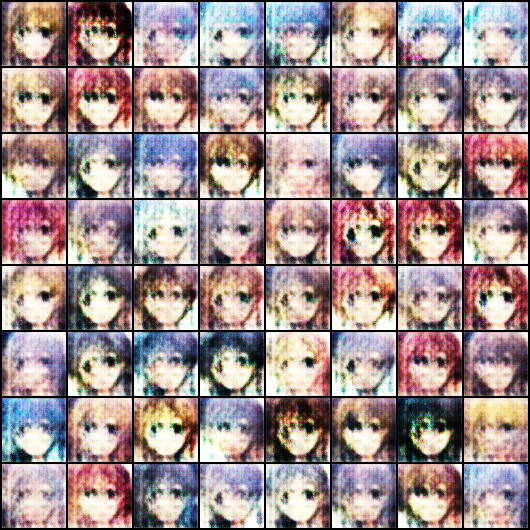

In [ ]:
from IPython.display import Image
Image('./generated/generated-images-0001.png')

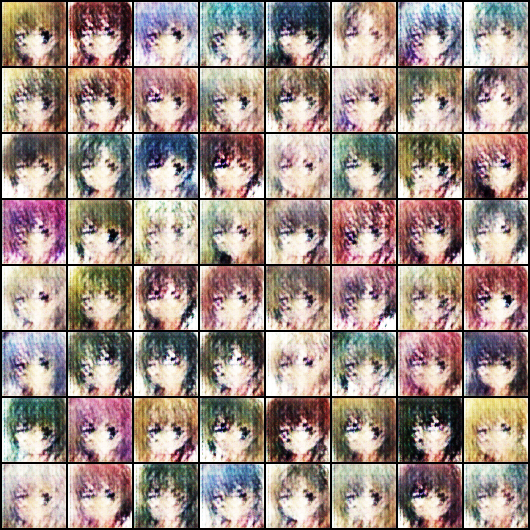

In [ ]:
Image('./generated/generated-images-0002.png')

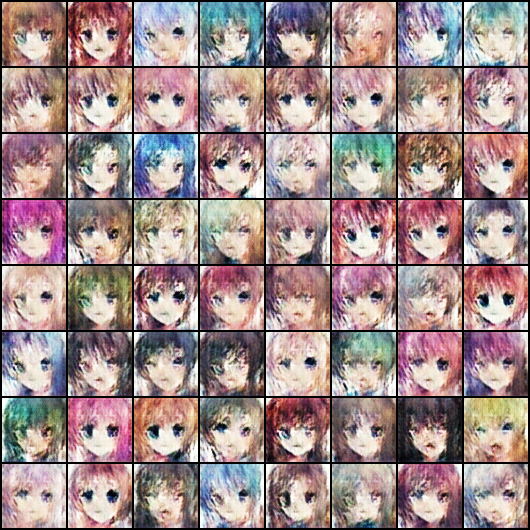

In [ ]:
Image('./generated/generated-images-0003.png')

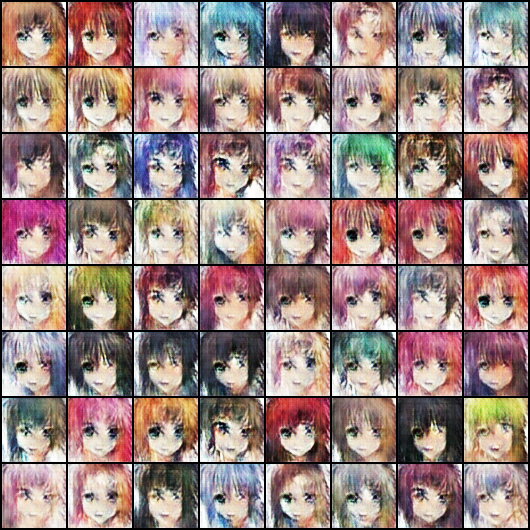

In [ ]:
Image('./generated/generated-images-0004.png')

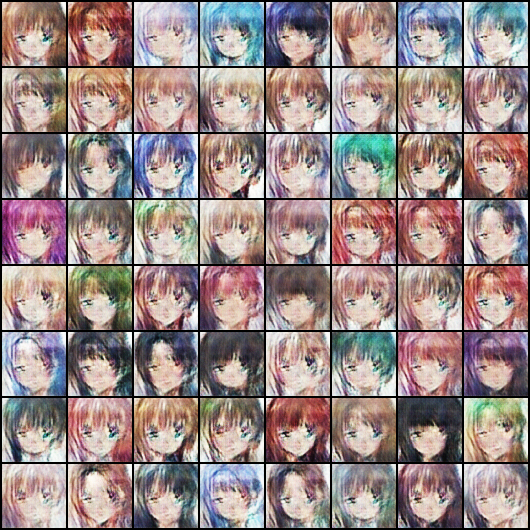

In [ ]:
Image('./generated/generated-images-0005.png')